# **Necessary Libs**

In [496]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms
from torchtext.data import Field, TabularDataset, BucketIterator
from sklearn.model_selection import train_test_split
import string
import numpy as np
from torch import nn
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import nltk
import torchvision.transforms as tfs
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import accuracy_score
from sklearn import  metrics

# **Read Data**

In [497]:
#http://analyticmunch.weebly.com/semeval-2010-task-8.html
import re
import csv

def read_line_by_line(file_txt):
    all_lines = []
    with open(file_txt, 'r') as file:
        temp_lines = file.readlines()
        for line in temp_lines:
            line = line.strip()
            if line:
                all_lines.append(line)
    return all_lines

def load_extract(file_txt):
    al_train = read_line_by_line(file_txt)
    train_raw = []
    i=0
    for line1 in al_train:
        train_raw.append(line1.split('|'))
        i = i+1
    #print train_raw
    odd = []
    even = []
#Removing the comment line, for the hackathon purpose we remove the comment line from text file
    for line in train_raw:
        com = re.compile(r"Comment:.*") 
        new = filter(com.match,line)
        if line == new:
            train_raw.remove(line)
        else:
            continue
    e1e2 = []
    for odd_line in train_raw:
        odd_string = ''.join(odd_line)
        oddmatch =re.sub('\t','',odd_string)
        k=oddmatch.lstrip('0123456789.-')
        asub = re.sub('<[^>]*>', '', k)
        odd_line2= asub.replace('"', '')
        e1e2.append(odd_line2)
    return e1e2


In [498]:
lineToInd = {'Cause-Effect(e1,e2)':0, 'Cause-Effect(e2,e1)':0,
              'Instrument-Agency(e1,e2)':1,'Instrument-Agency(e2,e1)':1,
              'Product-Producer(e1,e2)':2,'Product-Producer(e2,e1)':2,
             'Content-Container(e1,e2)':3, 'Content-Container(e2,e1)':3,
             'Entity-Origin(e1,e2)':4, 'Entity-Origin(e2,e1)':4,
             'Entity-Destination(e1,e2)':5, 'Entity-Destination(e2,e1)':5,
             'Component-Whole(e1,e2)':6,'Component-Whole(e2,e1)':6,
             'Member-Collection(e1,e2)':7,'Member-Collection(e2,e1)':7,
             'Message-Topic(e1,e2)':8,'Message-Topic(e2,e1)':8,
             'Entity-Destination(e1,e2)':5 ,'Other':9}

**Train**

In [499]:
dir = '../input/semeval2010-task-8/SemEval2010_task8_training/TRAIN_FILE.TXT'
text = load_extract(dir)
sentence = []
comment = []
relation = []
for cnt,line in enumerate(text):
  if cnt%3==0:
    sentence.append(line)
  elif cnt%3==1:
    relation.append(lineToInd[line])
  else:
    comment.append(line)
    
dataFrame = pd.DataFrame(list(zip(sentence, relation)),
               columns =['sentence', 'relation'])

In [500]:
dataFrame.to_csv('file_name.csv', index=False)

**Test**

In [501]:
dir = '../input/semeval2010-task-8/SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT'
text = load_extract(dir)
sentence = []
comment = []
relation = []
for cnt,line in enumerate(text):
  if cnt%3==0:
    sentence.append(line)
  elif cnt%3==1:
    relation.append(lineToInd[line])
  else:
    comment.append(line)
    
dataFrametest = pd.DataFrame(list(zip(sentence, relation)),
               columns =['sentence', 'relation'])

In [502]:
dataFrame.to_csv('file_nameTest.csv', index=False)

In [503]:
dataFrame

,sentence,relation
0,The system as described above has its greatest...,6
1,The child was carefully wrapped and bound into...,9
2,The author of a keygen uses a disassembler to ...,1
3,A misty ridge uprises from the surge.,9
4,The student association is the voice of the un...,7
...,...,...
7995,"When the notice is sent by fax, the notice is ...",9
7996,The herbicide is derived from a natural antibi...,4
7997,"To test this, we placed a kitchen match in the...",5
7998,The farmers and city officials in the region h...,9


In [504]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **Utilities**

In [505]:
def myTokenize(text):
    #return [tok.text.lower() for tok in spacy_en.tokenizer(text)]
    return nltk.word_tokenize(text)

def buildVocab(myDir):
  capt = Field(sequential=True, init_token='<SOS>', eos_token='<EOS>', pad_token='<PAD>', unk_token='<UNK>',
                use_vocab=True, tokenize=myTokenize, lower=True)
  fields = {"sentence": ("q", capt)}
  train_data = TabularDataset(path=myDir, format="csv", fields=fields)
  capt.build_vocab(train_data, max_size=10000, min_freq=1)
  return capt.vocab

def numericalize(text, vocab):
    tokenized_text = myTokenize(text)
    return [vocab.stoi[token] if token in vocab.stoi else vocab.stoi["<UNK>"] for token in tokenized_text]

def captionToInd(caption, vocab):
  return  [vocab.stoi["<SOS>"]] +  numericalize(caption, vocab) + [vocab.stoi["<EOS>"]]

# **Data Loader**

In [506]:
class RelationDataset(Dataset):
  def __init__(self, dataFrame, vocab):
    self.relationData = dataFrame
    self.vocab = vocab
  def __getitem__(self, idx):
    caption = self.relationData["sentence"].iloc[idx]
    captionInd = captionToInd(caption = caption, vocab = self.vocab)
    captionLabel = self.relationData["relation"].iloc[idx]
    return torch.tensor(captionInd), torch.tensor(captionLabel)
  def __len__(self):
    return len(self.relationData)


# **Vocabulary, Train/Test Loader**

In [507]:
myDir = 'file_name.csv'
myFileName = 'file_name.csv'
vocab  = buildVocab(myDir = myDir)

/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:52: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

**Train Dataset**

In [508]:
myDataFrame = pd.read_csv(myDir)
myDataFrame = myDataFrame.iloc[:7110]
for punc in string.punctuation+'\n':
      myDataFrame["sentence"] = myDataFrame.sentence.str.replace(punc, "")
myDataFrame["sentence"] = myDataFrame.sentence.str.lower()
trainDataFrame, valDataFrame = train_test_split(myDataFrame, test_size=0.05)
trainDataset = RelationDataset(dataFrame = trainDataFrame, vocab = vocab)
valDataset = RelationDataset(dataFrame = valDataFrame, vocab = vocab);

**Test Dataset**

In [509]:
myDataFrameTest = pd.read_csv('file_nameTest.csv')
for punc in string.punctuation+'\n':
      myDataFrameTest["sentence"] = myDataFrameTest.sentence.str.replace(punc, "")
testDataset = RelationDataset(dataFrame = myDataFrameTest, vocab = vocab);

In [510]:
#https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/image_captioning/get_loader.py
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    def __call__(self, batch):
        label = torch.tensor([item[1] for item in batch])
        targets = [item[0] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        return targets, label

In [511]:

pad_idx = trainDataset.vocab.stoi['<PAD>']

In [512]:
trainRelationData = DataLoader(trainDataset, batch_size=8, shuffle=True, num_workers=0,  pin_memory=True,
  collate_fn=MyCollate(pad_idx=pad_idx))

valRelationData = DataLoader(valDataset, batch_size=len(valDataset), shuffle=True, num_workers=0,  pin_memory=True,
  collate_fn=MyCollate(pad_idx=pad_idx))
testRelationData = DataLoader(testDataset, batch_size=2000, shuffle=True, num_workers=0,  pin_memory=True,
  collate_fn=MyCollate(pad_idx=pad_idx))

# **Models**

In [513]:
class RelationNet(nn.Module):
  def __init__(self, embeddingDim, hiddenDim, numLayers, vocabLen, classNumbers = 10):
    super(RelationNet, self).__init__()
    self.embedding = nn.Embedding(vocabLen, embeddingDim, max_norm=True)  #Parameters are true?
    self.lstm = nn.LSTM(embeddingDim, hiddenDim, num_layers  = numLayers, bidirectional = True, dropout = 0.5)
    self.linear = nn.Linear(in_features = 2*hiddenDim, out_features = classNumbers)
    self.dropout = nn.Dropout(0.7)
  def forward(self,caption):
    captEmbd =  self.dropout(self.embedding(caption))
    h, (hidden, cell) = self.lstm(captEmbd)
    cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
    linearOutput = self.linear(cat)
    outputs = F.softmax(linearOutput, dim=1)
    return outputs

# **Train Model**

In [514]:
def myPlot(epoch, trainLoss, yLebel, title, test = None):
  plt.xlabel('Epoch')
  plt.ylabel(yLebel)
  plt.title(title)
  plt.plot(epoch, trainLoss, label='Train')
  if test:
     plt.plot(epoch, test, label='Val')
  plt.legend(loc='upper left')
  plt.show()

In [515]:
def calcTestLoss(testloader, net, criterion):
  totalLoss = 0; i = 0
  net.eval()
  with torch.no_grad():
    for imgSample,  caption in testloader:
      if torch.cuda.is_available:
        imgSample = imgSample.cuda()
        caption =  caption.cuda()
      i +=1
      outputs = net(imgSample, caption[0:caption.shape[0]-1])
      loss = criterion(outputs.reshape(-1, outputs.shape[2]), caption.reshape(-1))
      totalLoss += loss.item()
  avgLoss = totalLoss/i
  return avgLoss

In [516]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [517]:
def accuracy(true, pred):
    acc = (true == pred.argmax(-1)).float().detach().cpu().numpy()
    return float(acc.sum() / len(acc))    

In [518]:
embeddingDim = 300
hiddenDim = 150
numLayers  = 2
vocabLen = len(trainDataset.vocab)
learningRate = 3e-4
numEpochs = 50
numClasses = 10

In [519]:
net = RelationNet(embeddingDim, hiddenDim, numLayers, vocabLen, numClasses)
if torch.cuda.is_available():
    net = net.cuda()
criterion = nn.CrossEntropyLoss(ignore_index=trainDataset.vocab.stoi["<PAD>"])
#optimizer = optim.Adam(net.parameters(), lr=learningRate)
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)

In [520]:
lossTrainHist = []
epochHist = []
accTrainHist = []
accvalHist = []

****************** Epoch: 1  ******************


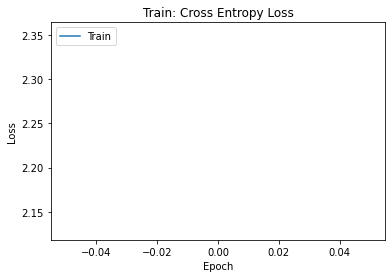

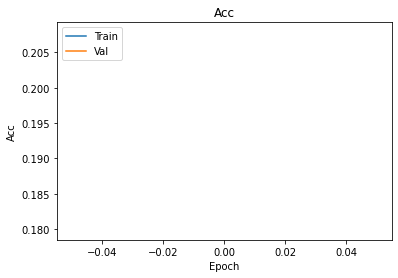

****************** Epoch: 2  ******************


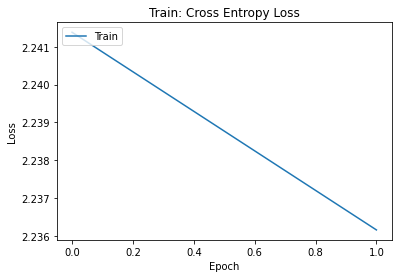

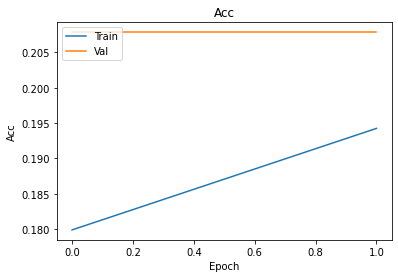

****************** Epoch: 3  ******************


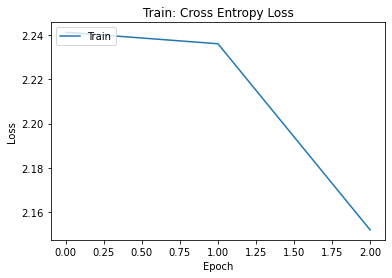

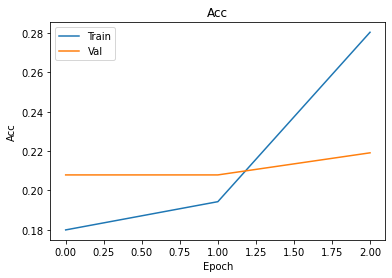

****************** Epoch: 4  ******************


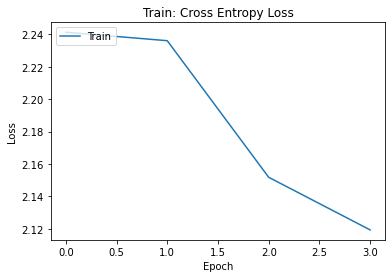

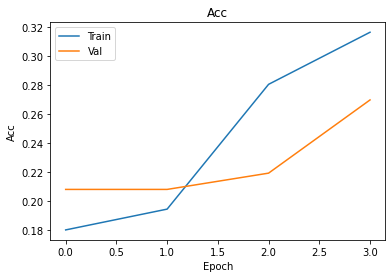

****************** Epoch: 5  ******************


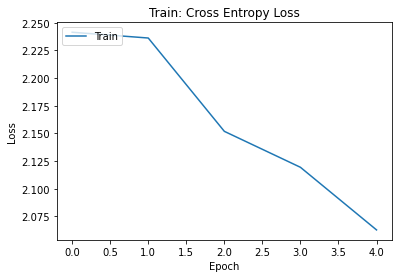

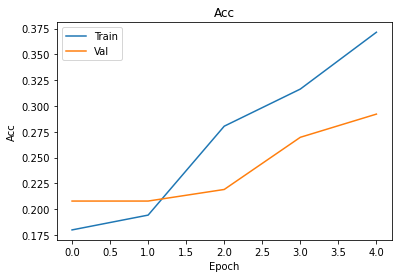

****************** Epoch: 6  ******************


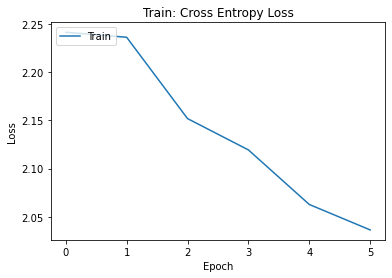

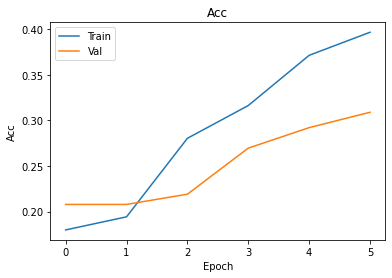

****************** Epoch: 7  ******************


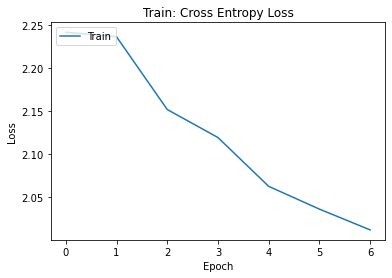

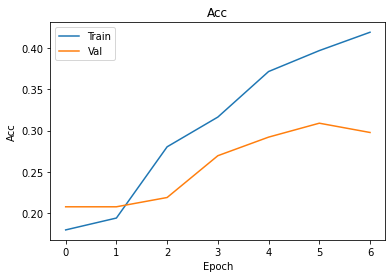

****************** Epoch: 8  ******************


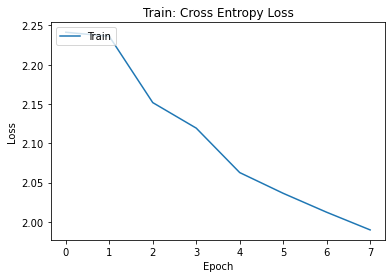

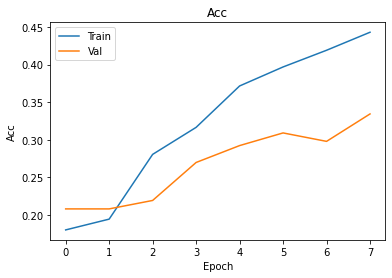

****************** Epoch: 9  ******************


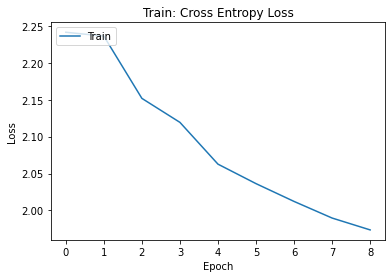

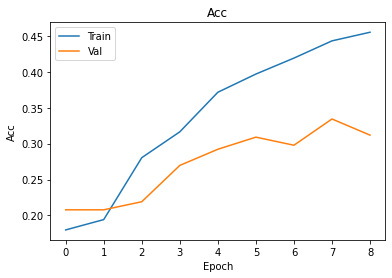

****************** Epoch: 10  ******************


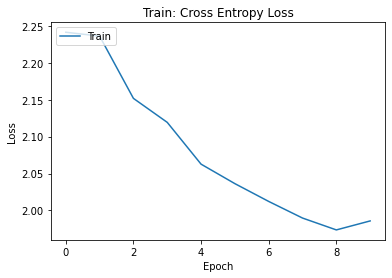

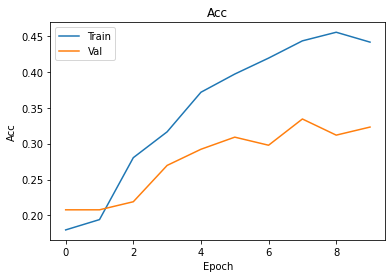

****************** Epoch: 11  ******************


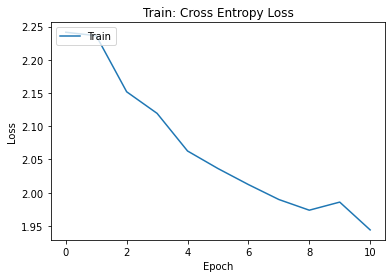

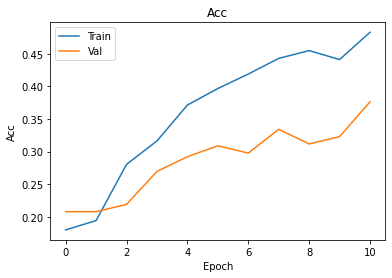

****************** Epoch: 12  ******************


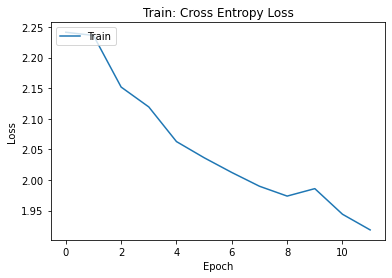

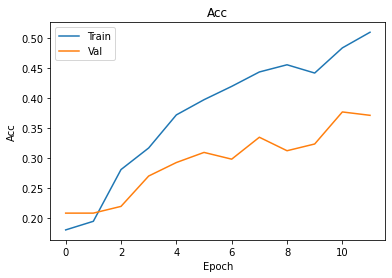

****************** Epoch: 13  ******************


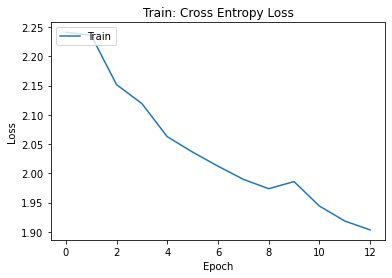

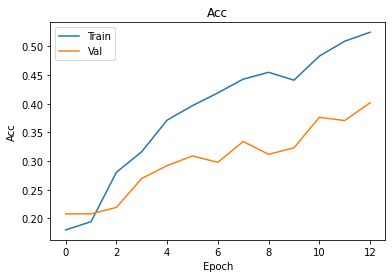

****************** Epoch: 14  ******************


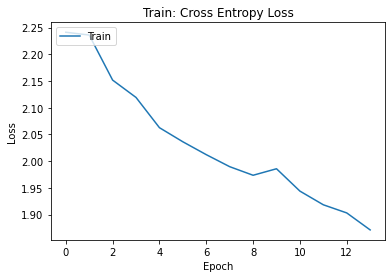

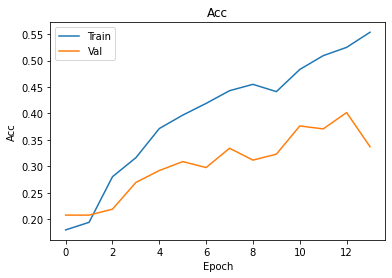

****************** Epoch: 15  ******************


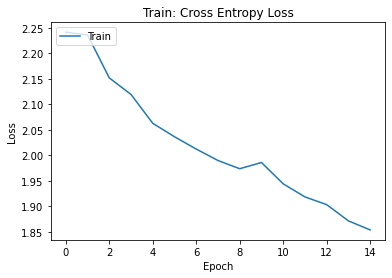

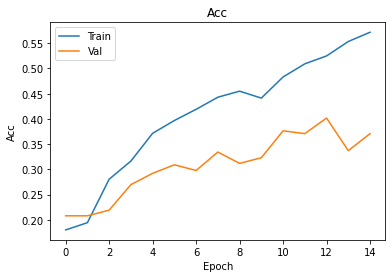

****************** Epoch: 16  ******************


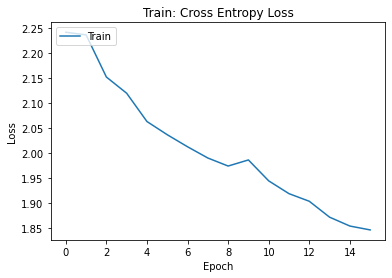

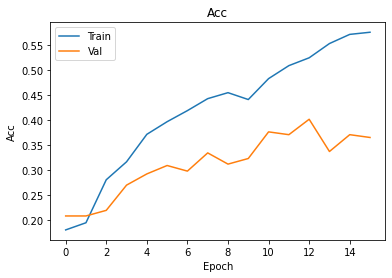

****************** Epoch: 17  ******************


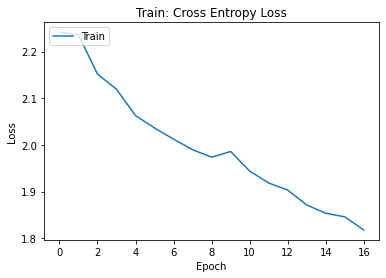

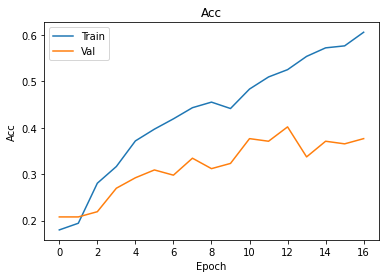

****************** Epoch: 18  ******************


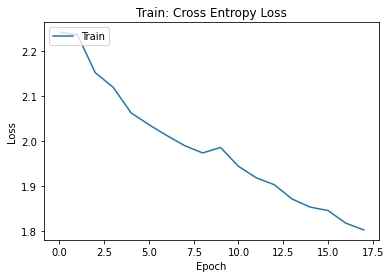

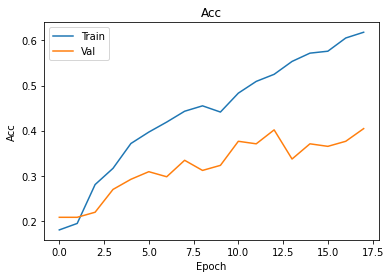

****************** Epoch: 19  ******************


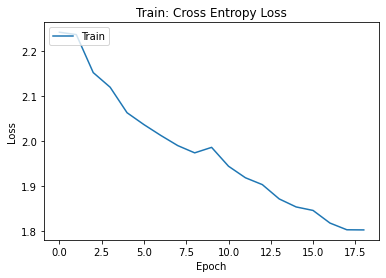

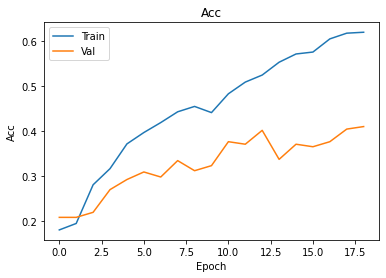

****************** Epoch: 20  ******************


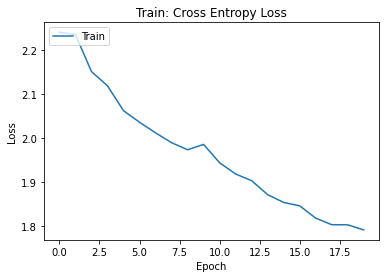

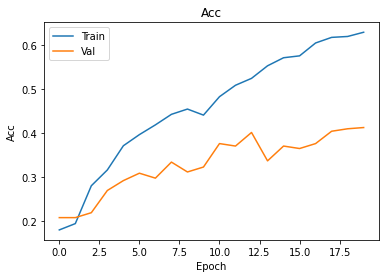

****************** Epoch: 21  ******************


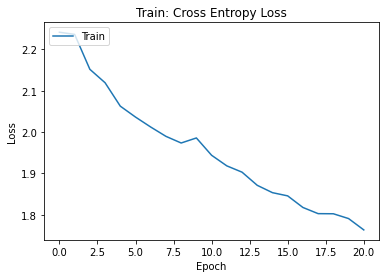

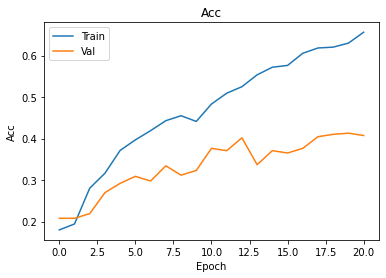

****************** Epoch: 22  ******************


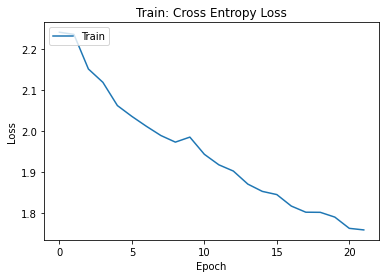

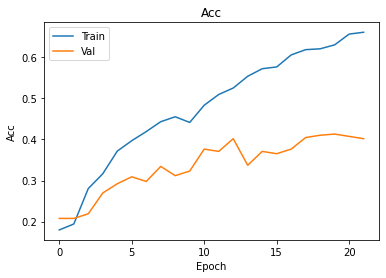

****************** Epoch: 23  ******************


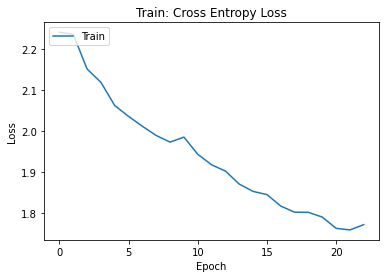

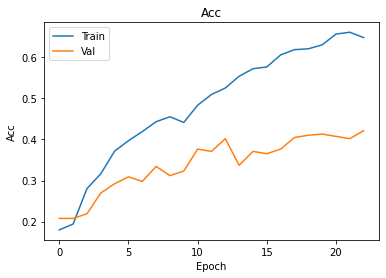

****************** Epoch: 24  ******************


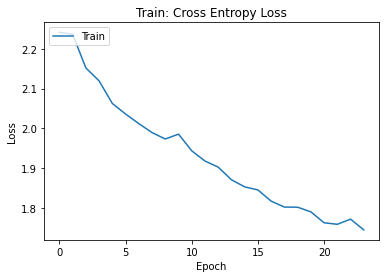

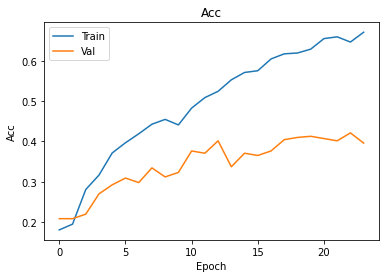

****************** Epoch: 25  ******************


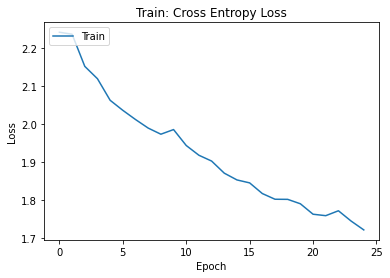

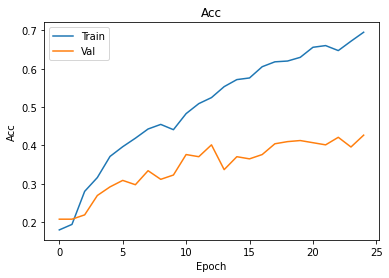

****************** Epoch: 26  ******************


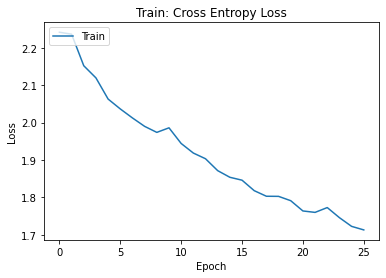

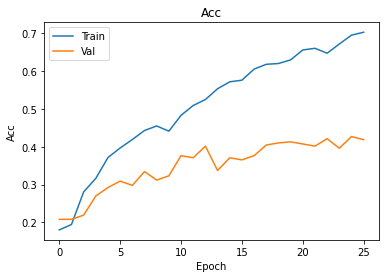

****************** Epoch: 27  ******************


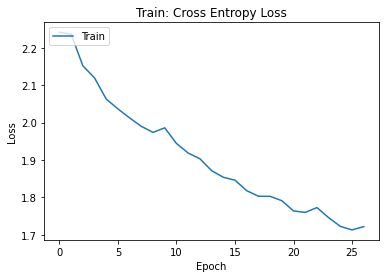

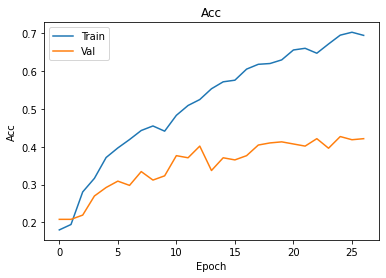

****************** Epoch: 28  ******************


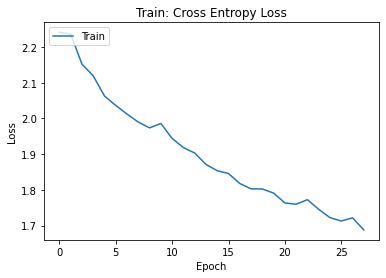

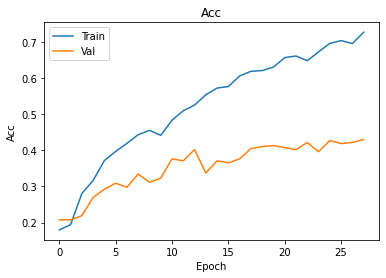

****************** Epoch: 29  ******************


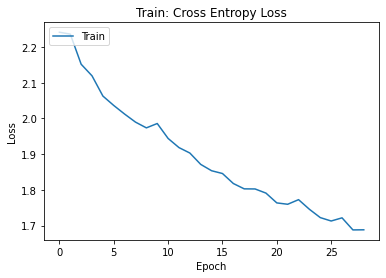

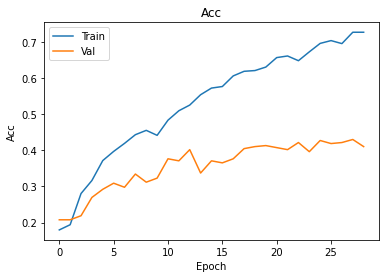

****************** Epoch: 30  ******************


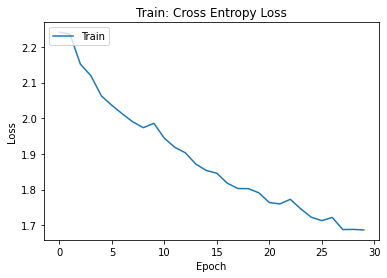

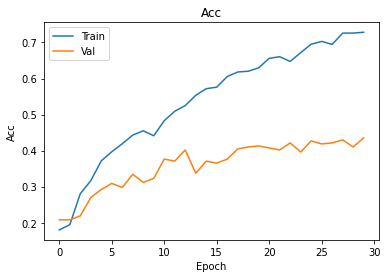

****************** Epoch: 31  ******************


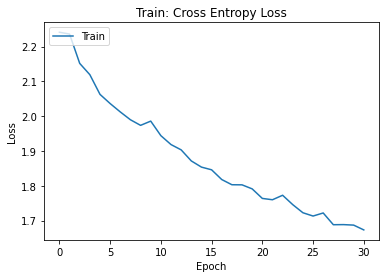

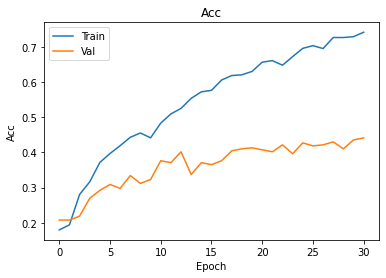

****************** Epoch: 32  ******************


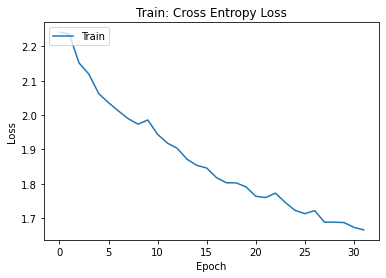

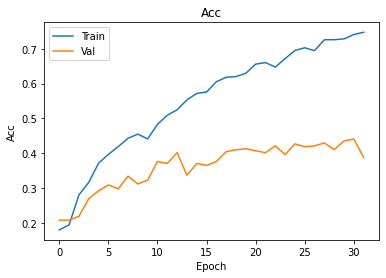

****************** Epoch: 33  ******************


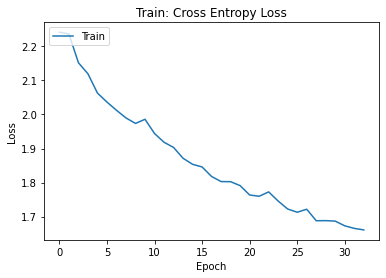

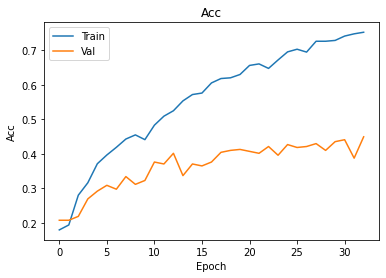

****************** Epoch: 34  ******************


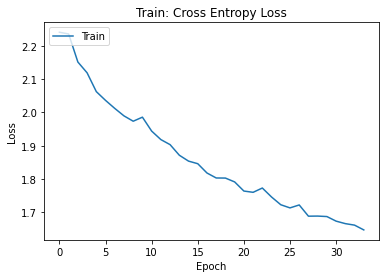

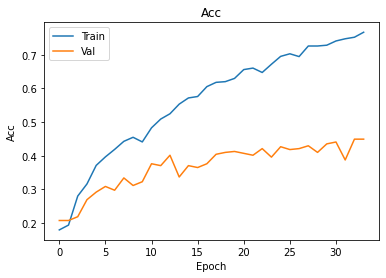

****************** Epoch: 35  ******************


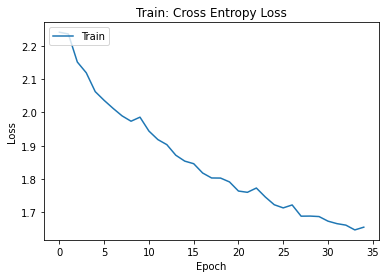

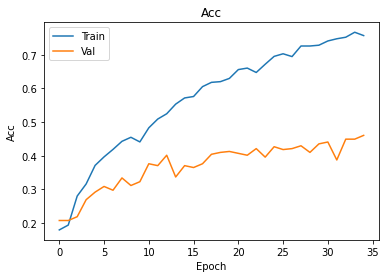

****************** Epoch: 36  ******************


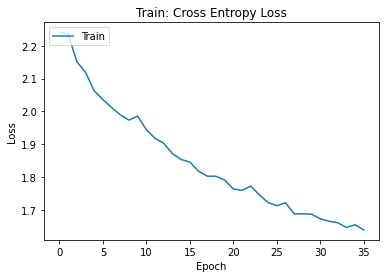

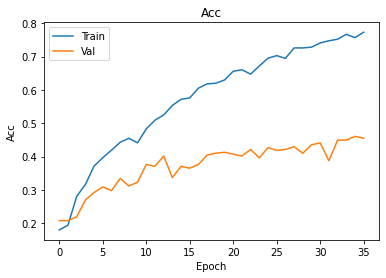

****************** Epoch: 37  ******************


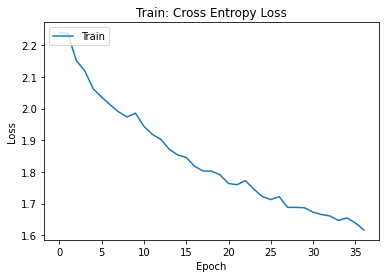

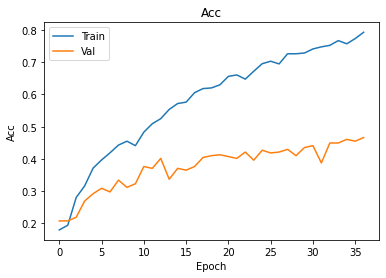

****************** Epoch: 38  ******************


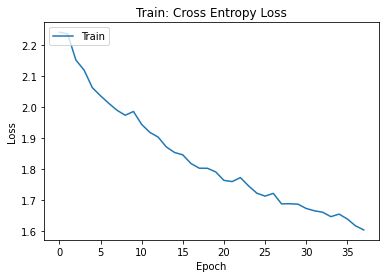

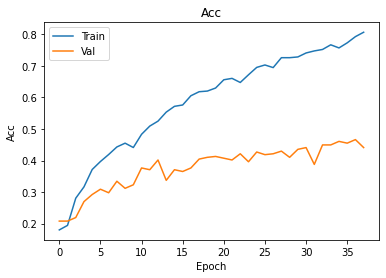

****************** Epoch: 39  ******************


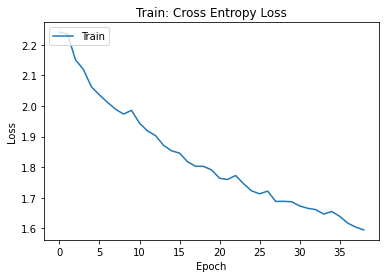

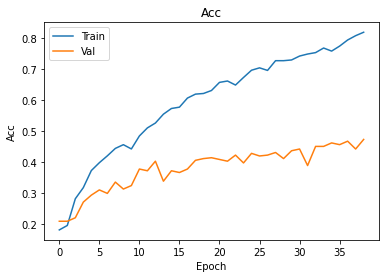

****************** Epoch: 40  ******************


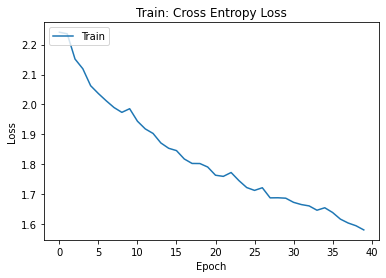

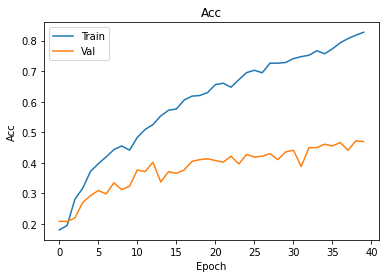

****************** Epoch: 41  ******************


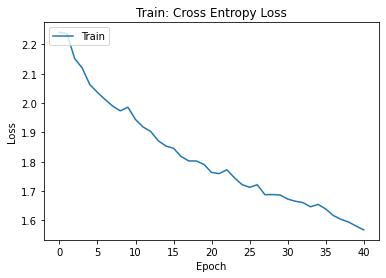

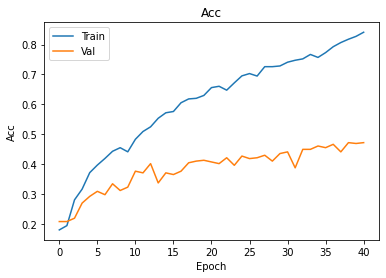

****************** Epoch: 42  ******************


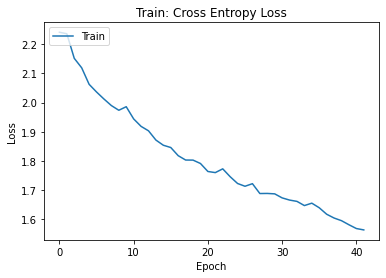

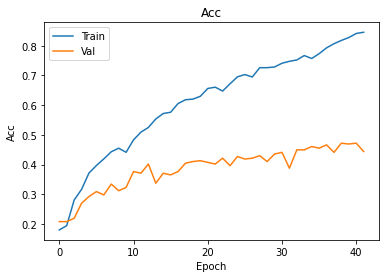

****************** Epoch: 43  ******************


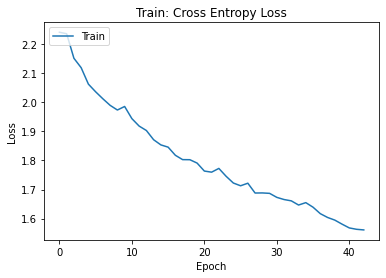

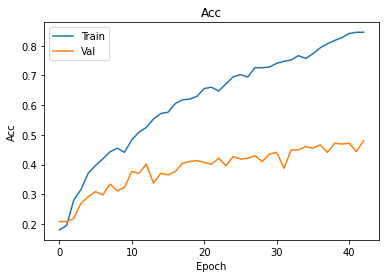

****************** Epoch: 44  ******************


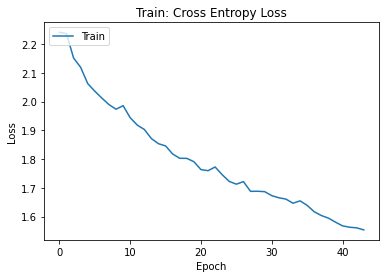

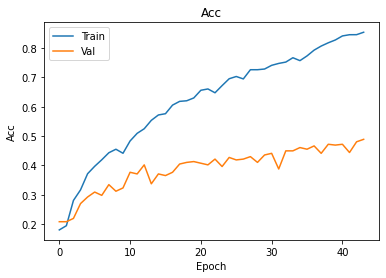

****************** Epoch: 45  ******************


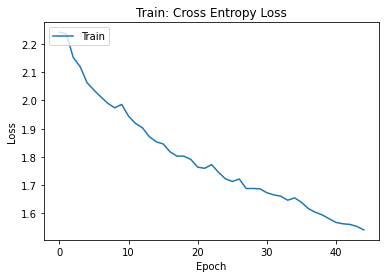

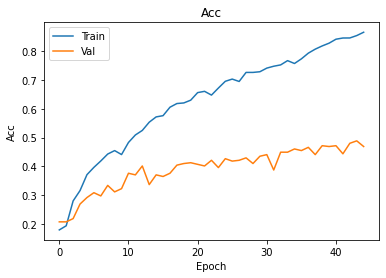

****************** Epoch: 46  ******************


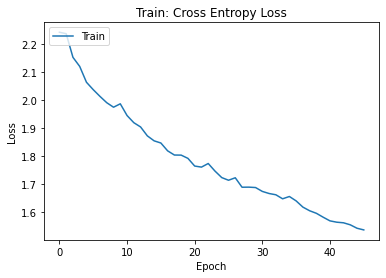

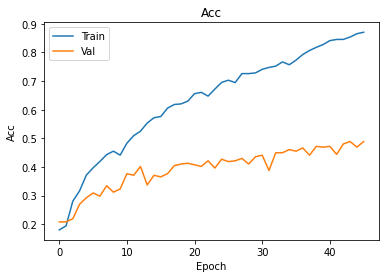

****************** Epoch: 47  ******************


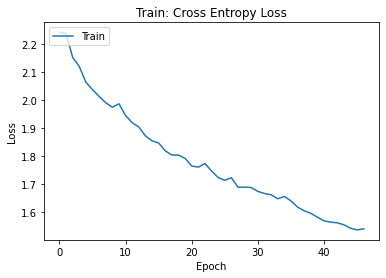

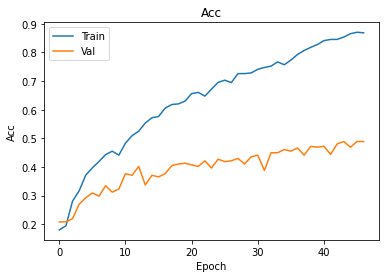

****************** Epoch: 48  ******************


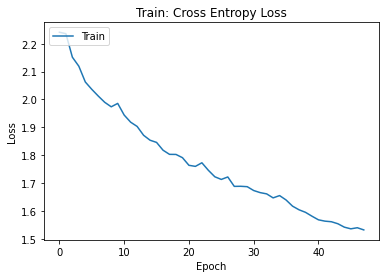

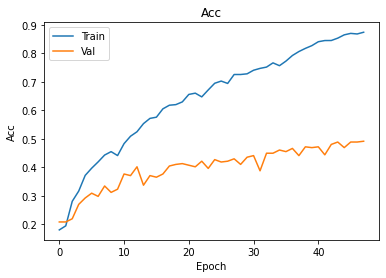

****************** Epoch: 49  ******************


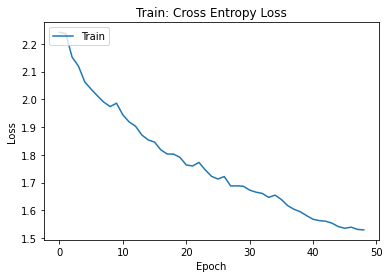

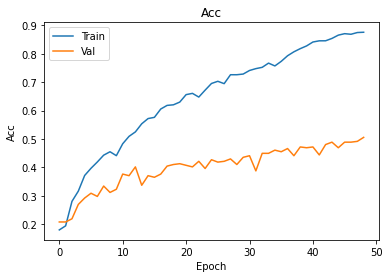

****************** Epoch: 50  ******************


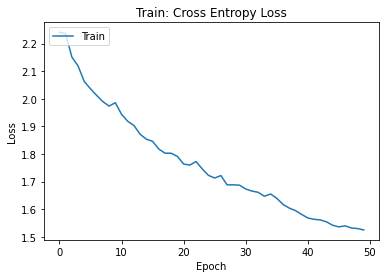

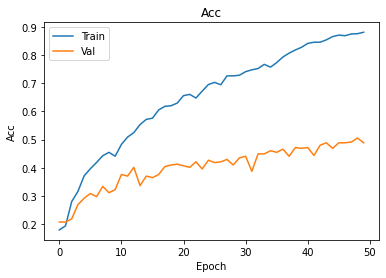

In [521]:
for epoch in range(numEpochs):
  net.train()
  stepTrain = 0; running_loss = 0; accTrain =0; lenDataTrain = 0
  print("****************** Epoch:", epoch+1," ******************")
  for caption,captionLabel in trainRelationData:
    if torch.cuda.is_available:
      caption =  Variable(caption).cuda()
      captionLabel =  Variable(captionLabel).cuda()
    else:
        caption = Variable(caption)
        captionLabel =  Variable(captionLabel)
    outputs = net(caption[0:caption.shape[0]-1])
    loss = criterion(outputs, captionLabel)
    running_loss += loss.item()
    stepTrain += 1
    optimizer.zero_grad()
    loss.backward(loss)
    optimizer.step()
    accTrain += (accuracy_score(captionLabel.cpu(), outputs.argmax(-1).cpu()))*len(captionLabel)
    lenDataTrain +=len(captionLabel)
  lossTrainHist.append(running_loss/stepTrain)
  accTrainHist.append(accTrain/lenDataTrain)
  epochHist.append(epoch)
  caption,captionLabel = next(iter(valRelationData))
  outputs = net(caption[0:caption.shape[0]-1].cuda())
  accvalHist.append((accuracy_score(captionLabel.cpu(), outputs.argmax(-1).cpu())))
  myPlot(epoch = epochHist, trainLoss = lossTrainHist, yLebel = 'Loss', title = 'Train: Cross Entropy Loss')
  myPlot(epoch = epochHist, trainLoss = accTrainHist, yLebel = 'Acc', title = 'Acc', test = accvalHist)

**Test Val**

In [522]:
results = []
label = []
for caption,captionLabel in testRelationData:
    myOutputs = net(caption[0:caption.shape[0]-1].cuda())
    results.append(myOutputs.detach().cpu().numpy())
    label.append(captionLabel.detach().cpu().numpy())

results = np.asarray(results)
label = np.asarray(label)
results = results.reshape(results.shape[0]*results.shape[1], results.shape[2])
label = label.reshape(label.shape[0]*label.shape[1])

In [523]:
np.shape(myOutputs.detach().cpu().numpy())

(2000, 10)

In [524]:
target_names = ['Cause-Effect', 'Instrument-Agency', 'Product-Producer','Content-Container',
                'Entity-Origin','Entity-Destination','Component-Whole','Member-Collection','Message-Topic','Other']
print(classification_report(label, results.argmax(-1), target_names=target_names))

                    precision    recall  f1-score   support

      Cause-Effect       0.91      0.82      0.86      1003
 Instrument-Agency       0.00      0.00      0.00       504
  Product-Producer       0.82      0.75      0.78       717
 Content-Container       0.64      0.91      0.75       540
     Entity-Origin       0.77      0.87      0.81       716
Entity-Destination       0.92      0.90      0.91       845
   Component-Whole       0.83      0.85      0.84       941
 Member-Collection       0.82      0.88      0.84       690
     Message-Topic       0.75      0.92      0.83       634
             Other       0.69      0.77      0.73      1410

          accuracy                           0.79      8000
         macro avg       0.71      0.77      0.74      8000
      weighted avg       0.75      0.79      0.76      8000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [525]:
#classification_report(captionLabel.cpu(), outputs.argmax(-1).cpu(), target_names=[0,1,2,3,4,5,6,7,8,9])
print("The accuracy of the model is: %.1f%%" % (accuracy_score(label, results.argmax(-1))*100))

The accuracy of the model is: 78.7%


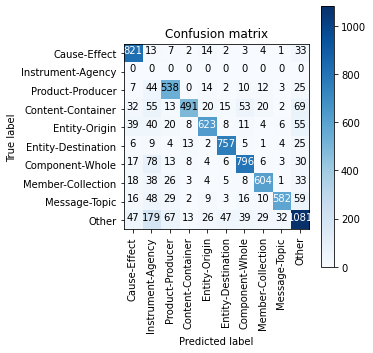

In [526]:
confusion_mtx = confusion_matrix(results.argmax(-1), label)
plot_confusion_matrix(confusion_mtx, target_names)

In [527]:
# target_names = ['Cause-Effect', 'Instrument-Agency', 'Product-Producer','Content-Container',
#                 'Entity-Origin','Entity-Destination','Component-Whole','Member-Collection','Message-Topic','Other']
# print(classification_report(captionLabel.cpu(), outputs.argmax(-1).cpu(), target_names=target_names))

In [528]:
# #classification_report(captionLabel.cpu(), outputs.argmax(-1).cpu(), target_names=[0,1,2,3,4,5,6,7,8,9])
# print("The accuracy of the model is: %.1f%%" % (accuracy_score(captionLabel.cpu(), outputs.argmax(-1).cpu())*100))

In [529]:
# confusion_mtx = confusion_matrix(outputs.argmax(-1).cpu(), captionLabel.cpu())
# plot_confusion_matrix(confusion_mtx, target_names)